<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [3]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [4]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

torch.set_grad_enabled(False)

/ais/clspace5/niu/envs/andrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [5]:
torch.cuda.empty_cache()

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [6]:
model_name = "gpt2-medium"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [7]:
predict_token(
    mt,
    ["Robert DeNiro is an", "The CN Tower is in the city of"],
    return_p=True,
)

([' an', ' Toronto'], tensor([0.1392, 0.1222], device='cuda:0'))

In [8]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
knowns[0:2]

Loaded dataset with 1209 elements


[{'known_id': 0,
  'subject': 'Vinson Massif',
  'attribute': 'Antarctica',
  'template': '{} is located in the continent',
  'prediction': ' of Antarctica. It is the largest of the three',
  'prompt': 'Vinson Massif is located in the continent of',
  'relation_id': 'P30'},
 {'known_id': 1,
  'subject': 'Beats Music',
  'attribute': 'Apple',
  'template': '{} is owned by',
  'prediction': ' Apple, which is also the owner of Beats Electronics',
  'prompt': 'Beats Music is owned by',
  'relation_id': 'P127'}]

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [9]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements


Using noise level 0.3257756531238556


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [10]:
#pass in the model, the input containing 10 copies of both the tokens and the attention, pass in the range for the subject tokens, pass in the answer, pass in noise

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

        

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [11]:
"thespaceneedle".index("space")

3

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [12]:
def calculate_hidden_flow(
    mt, prompt, target, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    #create 11 copies of tokens from our prompt sentence

    '''with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]

        #answer_t is what the model deems to be the highest probability label
        #base_score is the assigned probability
    

    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    print(answer_t)'''

    answer = target

    answer_t = mt.tokenizer.convert_tokens_to_ids(target)

    #answer is what the model fills the blank in with

    #pass in a tokenizer, the tokenized ids, and the subject
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

    #e_range contains [subject token start index, subject token end index], we will obfuscate/corrupt the tokens in this range


    #pass in the model, the input containing 10 copies of both the tokens and the attention, pass in the range for the subject tokens, pass in the answer, pass in noise
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()

    
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        #high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [20]:
def plot_hidden_flow(
    mt,
    prompt,
    target,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, target, subject, samples=samples, noise=noise, window=window, kind=kind
    )

    print(result["answer"], result["scores"])
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, target, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, target, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

themselves tensor([[1.4816e-03, 1.0581e-03, 2.0622e-03, 1.9293e-03, 1.9495e-03, 1.9469e-03,
         1.9690e-03, 1.9726e-03, 1.9725e-03, 1.9802e-03, 1.9882e-03, 1.9987e-03,
         2.0006e-03, 1.9802e-03, 1.9791e-03, 1.9750e-03, 1.9798e-03, 1.9763e-03,
         1.9734e-03, 1.9767e-03, 1.9821e-03, 1.9846e-03, 1.9924e-03, 1.9997e-03],
        [1.6134e-03, 1.6163e-03, 1.9548e-03, 2.4892e-03, 2.5800e-03, 2.6239e-03,
         2.3398e-03, 2.2869e-03, 2.3491e-03, 2.3568e-03, 2.2556e-03, 2.2173e-03,
         2.2439e-03, 2.2283e-03, 2.1596e-03, 2.1454e-03, 2.1109e-03, 2.0620e-03,
         2.0475e-03, 2.0414e-03, 2.0032e-03, 1.9915e-03, 1.9962e-03, 1.9997e-03],
        [1.3249e-03, 2.1968e-03, 2.5412e-03, 2.2122e-03, 2.3562e-03, 2.1667e-03,
         2.1437e-03, 2.2041e-03, 2.2216e-03, 2.2486e-03, 2.1782e-03, 2.1875e-03,
         2.1382e-03, 2.1134e-03, 2.0546e-03, 2.0411e-03, 2.0530e-03, 2.0282e-03,
         2.0200e-03, 1.9985e-03, 2.0152e-03, 2.0079e-03, 1.9888e-03, 1.9997e-03],
        [1.815

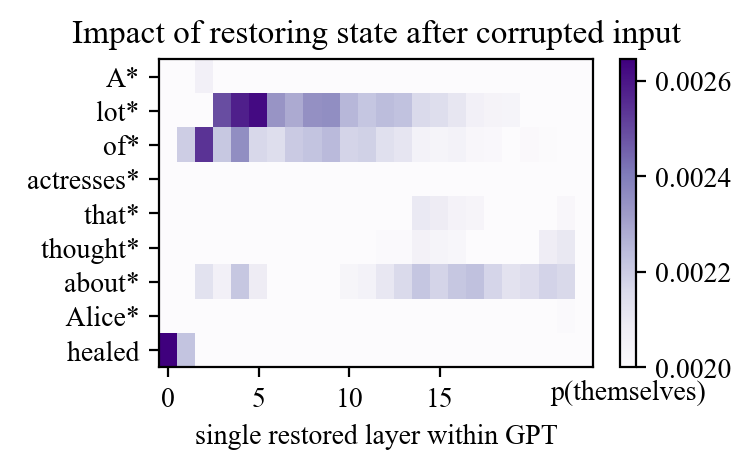

themselves tensor([[1.6025e-03, 1.6011e-03, 1.6009e-03, 1.6003e-03, 1.5992e-03, 1.5990e-03,
         2.0457e-03, 1.8736e-03, 2.0166e-03, 2.0084e-03, 2.0083e-03, 2.0015e-03,
         1.9996e-03, 1.9971e-03, 1.9971e-03, 1.9973e-03, 1.9932e-03, 1.9936e-03,
         1.9921e-03, 1.9924e-03, 1.9913e-03, 1.9919e-03, 1.9920e-03, 1.9932e-03],
        [1.4818e-03, 1.5145e-03, 1.4664e-03, 1.4257e-03, 1.3843e-03, 1.3831e-03,
         1.4958e-03, 2.1577e-03, 2.2993e-03, 2.6283e-03, 2.5604e-03, 2.3237e-03,
         2.1955e-03, 2.2263e-03, 2.0910e-03, 2.0878e-03, 2.2075e-03, 2.1399e-03,
         2.1075e-03, 2.1382e-03, 2.1083e-03, 2.0955e-03, 2.0553e-03, 2.0477e-03],
        [1.4209e-03, 1.4330e-03, 1.2475e-03, 1.2290e-03, 1.3588e-03, 1.2966e-03,
         2.4045e-03, 2.6008e-03, 2.1509e-03, 1.9744e-03, 1.8228e-03, 1.9574e-03,
         2.0041e-03, 2.1125e-03, 2.0640e-03, 2.0203e-03, 2.0027e-03, 1.9657e-03,
         1.9481e-03, 1.9726e-03, 1.9570e-03, 1.9939e-03, 1.9697e-03, 1.9709e-03],
        [1.901

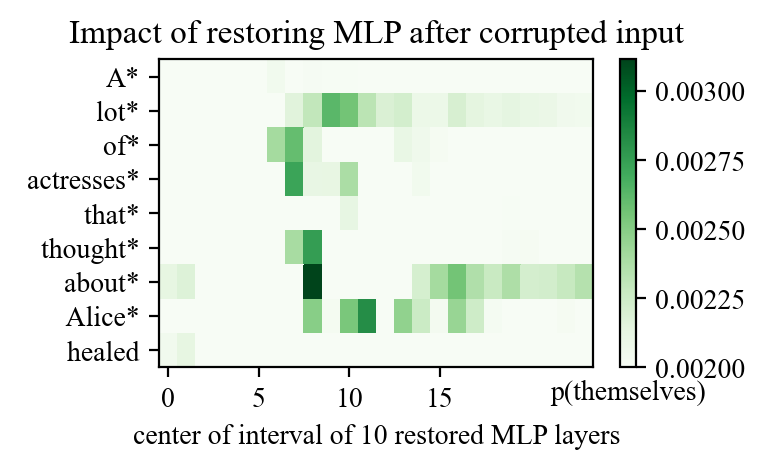

themselves tensor([[1.6799e-03, 1.6804e-03, 1.6824e-03, 1.6823e-03, 1.6831e-03, 1.6822e-03,
         1.6999e-03, 1.8805e-03, 1.9951e-03, 2.0029e-03, 2.0029e-03, 2.0022e-03,
         2.0017e-03, 2.0013e-03, 2.0002e-03, 2.0036e-03, 2.0044e-03, 2.0046e-03,
         2.0037e-03, 2.0034e-03, 2.0031e-03, 2.0028e-03, 2.0019e-03, 2.0016e-03],
        [2.3572e-03, 2.4618e-03, 2.4561e-03, 2.4025e-03, 2.4053e-03, 2.4022e-03,
         2.1300e-03, 1.9249e-03, 2.1500e-03, 2.3007e-03, 2.2006e-03, 2.0908e-03,
         2.0563e-03, 2.0639e-03, 2.0259e-03, 2.0409e-03, 2.0329e-03, 2.0307e-03,
         2.0214e-03, 2.0133e-03, 2.0031e-03, 2.0000e-03, 1.9995e-03, 1.9959e-03],
        [2.2301e-03, 2.2103e-03, 2.2088e-03, 2.2086e-03, 2.2169e-03, 2.2072e-03,
         2.2647e-03, 1.8833e-03, 1.8681e-03, 2.2266e-03, 2.0159e-03, 1.9604e-03,
         1.9525e-03, 2.0018e-03, 1.9868e-03, 2.0442e-03, 2.0180e-03, 2.0015e-03,
         2.0185e-03, 2.0099e-03, 2.0133e-03, 2.0045e-03, 2.0130e-03, 2.0071e-03],
        [1.464

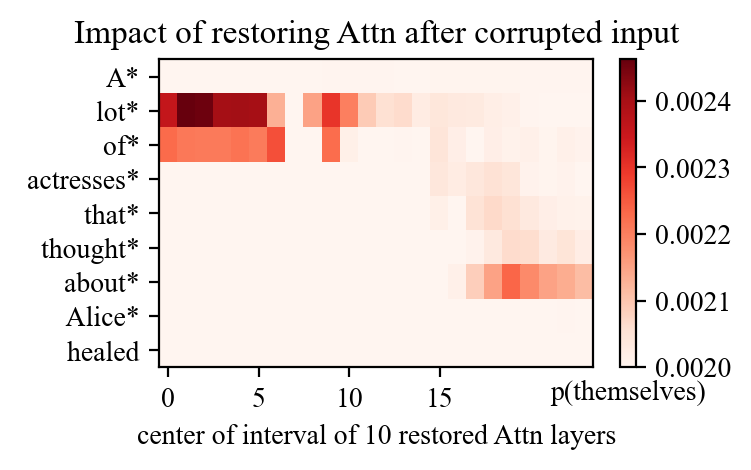

herself tensor([[1.4816e-03, 1.0581e-03, 2.0622e-03, 1.9293e-03, 1.9495e-03, 1.9469e-03,
         1.9690e-03, 1.9726e-03, 1.9725e-03, 1.9802e-03, 1.9882e-03, 1.9987e-03,
         2.0006e-03, 1.9802e-03, 1.9791e-03, 1.9750e-03, 1.9798e-03, 1.9763e-03,
         1.9734e-03, 1.9767e-03, 1.9821e-03, 1.9846e-03, 1.9924e-03, 1.9997e-03],
        [1.6134e-03, 1.6163e-03, 1.9548e-03, 2.4892e-03, 2.5800e-03, 2.6239e-03,
         2.3398e-03, 2.2869e-03, 2.3491e-03, 2.3568e-03, 2.2556e-03, 2.2173e-03,
         2.2439e-03, 2.2283e-03, 2.1596e-03, 2.1454e-03, 2.1109e-03, 2.0620e-03,
         2.0475e-03, 2.0414e-03, 2.0032e-03, 1.9915e-03, 1.9962e-03, 1.9997e-03],
        [1.3249e-03, 2.1968e-03, 2.5412e-03, 2.2122e-03, 2.3562e-03, 2.1667e-03,
         2.1437e-03, 2.2041e-03, 2.2216e-03, 2.2486e-03, 2.1782e-03, 2.1875e-03,
         2.1382e-03, 2.1134e-03, 2.0546e-03, 2.0411e-03, 2.0530e-03, 2.0282e-03,
         2.0200e-03, 1.9985e-03, 2.0152e-03, 2.0079e-03, 1.9888e-03, 1.9997e-03],
        [1.8156e-

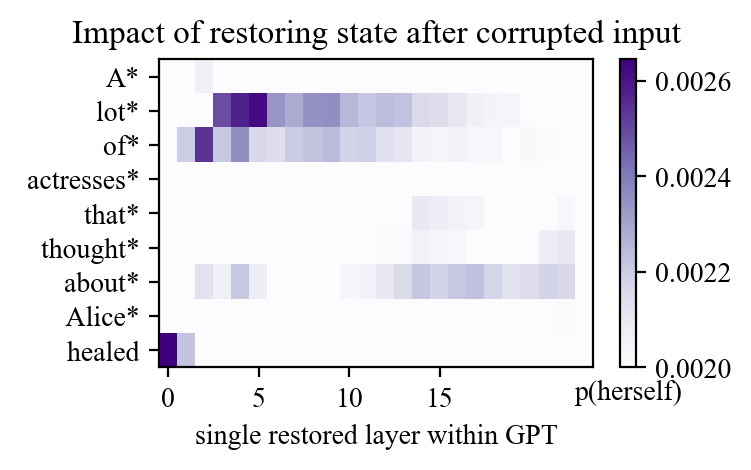

herself tensor([[1.6025e-03, 1.6011e-03, 1.6009e-03, 1.6003e-03, 1.5992e-03, 1.5990e-03,
         2.0457e-03, 1.8736e-03, 2.0166e-03, 2.0084e-03, 2.0083e-03, 2.0015e-03,
         1.9996e-03, 1.9971e-03, 1.9971e-03, 1.9973e-03, 1.9932e-03, 1.9936e-03,
         1.9921e-03, 1.9924e-03, 1.9913e-03, 1.9919e-03, 1.9920e-03, 1.9932e-03],
        [1.4818e-03, 1.5145e-03, 1.4664e-03, 1.4257e-03, 1.3843e-03, 1.3831e-03,
         1.4958e-03, 2.1577e-03, 2.2993e-03, 2.6283e-03, 2.5604e-03, 2.3237e-03,
         2.1955e-03, 2.2263e-03, 2.0910e-03, 2.0878e-03, 2.2075e-03, 2.1399e-03,
         2.1075e-03, 2.1382e-03, 2.1083e-03, 2.0955e-03, 2.0553e-03, 2.0477e-03],
        [1.4209e-03, 1.4330e-03, 1.2475e-03, 1.2290e-03, 1.3588e-03, 1.2966e-03,
         2.4045e-03, 2.6008e-03, 2.1509e-03, 1.9744e-03, 1.8228e-03, 1.9574e-03,
         2.0041e-03, 2.1125e-03, 2.0640e-03, 2.0203e-03, 2.0027e-03, 1.9657e-03,
         1.9481e-03, 1.9726e-03, 1.9570e-03, 1.9939e-03, 1.9697e-03, 1.9709e-03],
        [1.9010e-

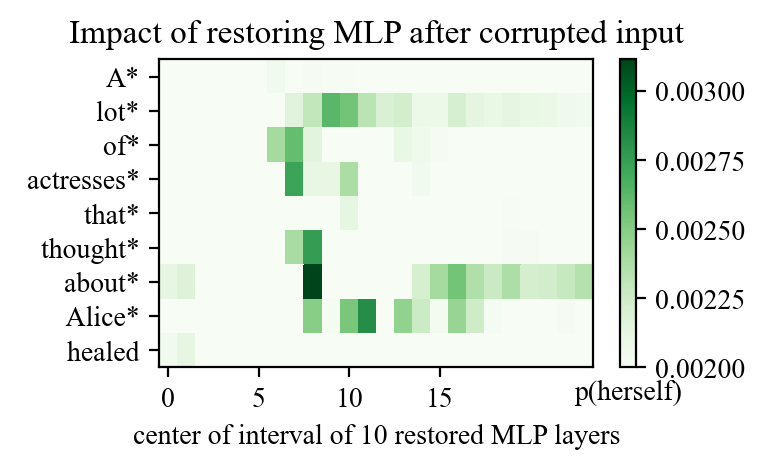

herself tensor([[1.6799e-03, 1.6804e-03, 1.6824e-03, 1.6823e-03, 1.6831e-03, 1.6822e-03,
         1.6999e-03, 1.8805e-03, 1.9951e-03, 2.0029e-03, 2.0029e-03, 2.0022e-03,
         2.0017e-03, 2.0013e-03, 2.0002e-03, 2.0036e-03, 2.0044e-03, 2.0046e-03,
         2.0037e-03, 2.0034e-03, 2.0031e-03, 2.0028e-03, 2.0019e-03, 2.0016e-03],
        [2.3572e-03, 2.4618e-03, 2.4561e-03, 2.4025e-03, 2.4053e-03, 2.4022e-03,
         2.1300e-03, 1.9249e-03, 2.1500e-03, 2.3007e-03, 2.2006e-03, 2.0908e-03,
         2.0563e-03, 2.0639e-03, 2.0259e-03, 2.0409e-03, 2.0329e-03, 2.0307e-03,
         2.0214e-03, 2.0133e-03, 2.0031e-03, 2.0000e-03, 1.9995e-03, 1.9959e-03],
        [2.2301e-03, 2.2103e-03, 2.2088e-03, 2.2086e-03, 2.2169e-03, 2.2072e-03,
         2.2647e-03, 1.8833e-03, 1.8681e-03, 2.2266e-03, 2.0159e-03, 1.9604e-03,
         1.9525e-03, 2.0018e-03, 1.9868e-03, 2.0442e-03, 2.0180e-03, 2.0015e-03,
         2.0185e-03, 2.0099e-03, 2.0133e-03, 2.0045e-03, 2.0130e-03, 2.0071e-03],
        [1.4646e-

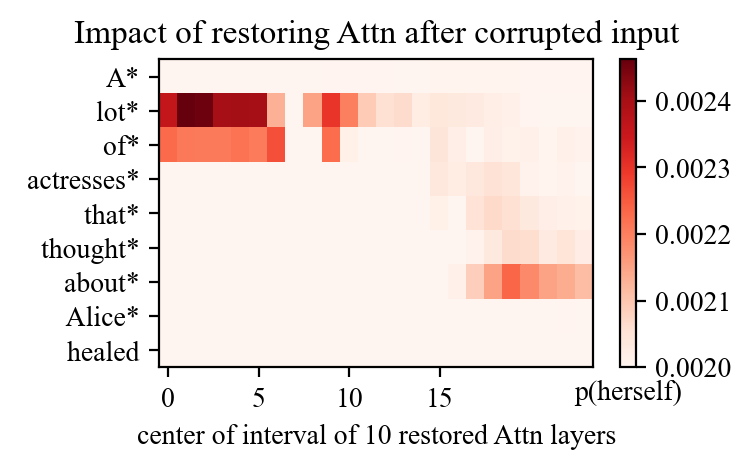

In [21]:
plot_all_flow(mt, "A lot of actresses that thought about Alice healed", target = "themselves", subject="A lot of actresses that thought about Alice", noise=noise_level)
plot_all_flow(mt, "A lot of actresses that thought about Alice healed", target = "herself", subject="A lot of actresses that thought about Alice", noise=noise_level)

Here we trace a few more factual statements from a file of test cases.

In [15]:
#for knowledge in knowns[:5]:
    #plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)